# What's New - 2017 Holiday Edition

* Better automated visualization and peak statistics via the "Best-Effort Callback" and hints
* More convenient ways to access saved data
* Easier-to-use "supplemental data": baseline readings and asynchronous acquisition (monitoring and flying)

## Better automated visualization and peak statistics via the "Best-Effort Callback" and hints

In [1]:
# Make plotting interative in the notebook.
%matplotlib notebook
from bluesky.utils import install_nb_kicker
install_nb_kicker()

# Create a RunEngine.
from bluesky import RunEngine
RE = RunEngine({})

from bluesky.plans import scan
from ophyd.sim import det, motor  # simulated Devices

# Simulate the motor movement.
motor.delay = 0.5

In [2]:
d = [det]  # my list of detectors

### The Bad Old Days

Recall that a vanilla RunEngine gives no useful visual feedback. In bluesky jargon, there are no callbacks subscribed to receive the data.

In [3]:
RE(scan(d, motor, -1, 1, 5))

('364d90d0-11b8-42fa-88d4-227fbddff895',)

Getting a table and a plot required either:
* writing custom plans that subscribed certain callbacks (for example, `ct` and `ascan` did this)
* passing in callbacks as arguments, such as

  ```python
  RE(scan(d, motor, -1, 1, 5), [LiveTable(['det', 'motor']), LivePlot('det', 'motor')])
  ```
  
Sometimes this level of power and flexbility is awesome, but usually this is obnoxiously verbose just to get a table and a plot!

_There must be a better way!_

### A Table and a Plot for Every Occasion

In [4]:
# Set up the BestEffortCallback.
from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()
RE.subscribe(bec)  # permanently attached to the RunEngine itself, applying to all future executions

peaks = bec.peaks  # just as alias for less typing

Transient Scan ID: 2     Time: 2017/12/14 00:43:56
Persistent Unique Scan ID: 'c43527ee-c43c-4894-a13e-ed1b5704f620'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+


<IPython.core.display.Javascript object>


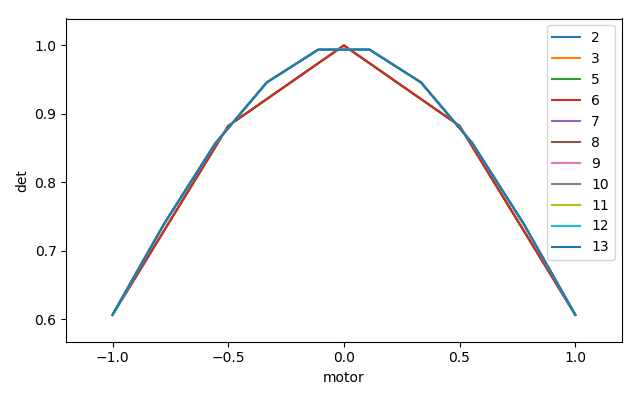

|         1 | 00:43:57.0 |     -1.000 |      0.607 |
|         2 | 00:43:57.5 |     -0.500 |      0.882 |
|         3 | 00:43:58.1 |      0.000 |      1.000 |
|         4 | 00:43:58.6 |      0.500 |      0.882 |
|         5 | 00:43:59.1 |      1.000 |      0.607 |
+-----------+------------+------------+------------+
generator scan ['c43527'] (scan num: 2)





('c43527ee-c43c-4894-a13e-ed1b5704f620',)

In [5]:
RE(scan(d, motor, -1, 1, 5))

How does the callback decide what to plot, and which columns to show? There are often a multiple choices, and not enough room to just show everything.

In [6]:
motor.describe()

OrderedDict([('motor',
              {'dtype': 'number',
               'precision': 3,
               'shape': [],
               'source': 'SIM:motor'}),
             ('motor_setpoint',
              {'dtype': 'number',
               'precision': 3,
               'shape': [],
               'source': 'SIM:motor_setpoint'})])

The Device(s) (``det``, ``motor``) and the plan (``scan``) provide **hints**.

In [7]:
# Devices and Signals have a new (optional) 'hints' attribute.

motor.hints

{'fields': ['motor']}

In [8]:
# Plans provide 'hints' in their metadata. We can see that by printing it.

def print_hints_metadata(name, doc):
    if name == 'start':
        # Prints hints if they exist.
        print('HINTS:', doc.get('hints', 'NO HINTS WERE GIVEN'))

RE(scan(d, motor, -1, 1, 5), print_hints_metadata)

Transient Scan ID: 3     Time: 2017/12/14 00:43:59
Persistent Unique Scan ID: 'cf53803f-8f9d-4c23-927b-0c3089cb6f39'
HINTS: {'dimensions': [(['motor'], 'primary')]}
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 00:44:00.0 |     -1.000 |      0.607 |
|         2 | 00:44:00.6 |     -0.500 |      0.882 |
|         3 | 00:44:01.1 |      0.000 |      1.000 |
|         4 | 00:44:01.6 |      0.500 |      0.882 |
|         5 | 00:44:02.1 |      1.000 |      0.607 |
+-----------+------------+------------+------------+
generator scan ['cf5380'] (scan num: 3)





('cf53803f-8f9d-4c23-927b-0c3089cb6f39',)

### About Hints

* The hints are not always guaranteed to be correct -- hence the "Best-Effort" in Best-Effort Callback.
* They are intentionally generic, intended to be future-proof.
* They are an experimental feature that will likely be extended and changed in the future.

### Bonus Feature: Click the plot and hit P (capital P!)

Peak stats are always on the in background. Of course they don't always make physical sense; it's up to you whether to decide to look at them.

In [9]:
peaks

{
'com':
    {'det': 0.0}
,
'cen':
    {'det': 0.0}
,
'max':
    {'det': (0.0,
             1.0)}
,
'min':
    {'det': (-1.0,
             0.60653065971263342)}
,
'fwhm':
    {'det': 1.2871060311714981}
,
'nlls':
    {'det': None}
,
}

Here's a simple plan that uses `peaks` to implement what SPEC users know as "cen" -- moving the motor to the center of the peak.

In [10]:
from bluesky.plan_stubs import mv, input_plan

def cen():
    pos = peaks['cen']['det']
    print(f'Moving motor to {pos}')
    yield from mv(motor, pos)

In [11]:
RE(cen())

Moving motor to 0.0


()

## More convenient ways to access saved data

In [12]:
# For demo purposes, we set up a Broker backed by a temporary directory
# containing JSON files and a sqlite database.
# In production, a Broker is usually backed by a Mongo database.
import os
import tempfile
tempdir = tempfile.mkdtemp()
config = {
    'description': 'temporary',
    'metadatastore': {
        'module': 'databroker.headersource.mongoquery',
        'class': 'MDS',
        'config': {
            'directory': tempdir,
            'timezone': 'US/Eastern'}
    },
    'assets': {
        'module': 'databroker.assets.sqlite',
        'class': 'Registry',
        'config': {
            'dbpath': os.path.join(tempdir, 'assets.sqlite')}
    }
}
from databroker import Broker
db = Broker.from_config(config)

# Send all data from RE into db.
RE.subscribe(db.insert)

2

Transient Scan ID: 4     Time: 2017/12/14 00:44:04
Persistent Unique Scan ID: '96b2f772-6c18-47d4-a0a4-5cebfa964ce4'
New stream: 'primary'
+-----------+------------+------------+---------------+
|   seq_num |       time |      motor | det_intensity |
+-----------+------------+------------+---------------+


<IPython.core.display.Javascript object>


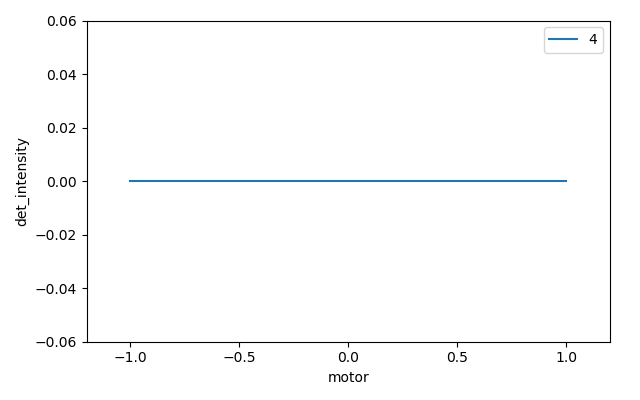

|         1 | 00:44:04.9 |     -1.000 |         0.000 |
|         2 | 00:44:05.5 |     -0.500 |         0.000 |
|         3 | 00:44:06.0 |      0.000 |         0.000 |
|         4 | 00:44:06.5 |      0.500 |         0.000 |
|         5 | 00:44:07.0 |      1.000 |         0.000 |
+-----------+------------+------------+---------------+
generator scan ['96b2f7'] (scan num: 4)





/Users/dallan/miniconda3/envs/tutorial/lib/python3.6/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]


('96b2f772-6c18-47d4-a0a4-5cebfa964ce4',)

In [13]:
# Use a more complex (realistic) simulated detector that has some configuration.
from ophyd.sim import det_with_count_time
det_with_count_time.configuration_attrs.append('count_time')
det_with_count_time.count_time.set(1)

# Take some data. Pretty boring data.
RE(scan([det_with_count_time], motor, -1, 1, 5))

### The Old Way (it still works, but it's rarely the best way)

In [14]:
h = db[-1]
db.get_table(h)

,time,det_intensity,motor,motor_setpoint
seq_num,,,,
1,2017-12-14 00:44:04.957404,0,-1.0,-1.0
2,2017-12-14 00:44:05.533740,0,-0.5,-0.5
3,2017-12-14 00:44:06.049973,0,0.0,0.0
4,2017-12-14 00:44:06.559471,0,0.5,0.5
5,2017-12-14 00:44:07.070192,0,1.0,1.0


Why should I have to type `db` twice?

### The New Way

In [15]:
h = db[-1]
h.table()

,time,det_intensity,motor,motor_setpoint
seq_num,,,,
1,2017-12-14 00:44:04.957404,0,-1.0,-1.0
2,2017-12-14 00:44:05.533740,0,-0.5,-0.5
3,2017-12-14 00:44:06.049973,0,0.0,0.0
4,2017-12-14 00:44:06.559471,0,0.5,0.5
5,2017-12-14 00:44:07.070192,0,1.0,1.0


In [16]:
# or, if you don't need `h` for anything else, do it in one line
db[-1].table()

,time,det_intensity,motor,motor_setpoint
seq_num,,,,
1,2017-12-14 00:44:04.957404,0,-1.0,-1.0
2,2017-12-14 00:44:05.533740,0,-0.5,-0.5
3,2017-12-14 00:44:06.049973,0,0.0,0.0
4,2017-12-14 00:44:06.559471,0,0.5,0.5
5,2017-12-14 00:44:07.070192,0,1.0,1.0


### There are a lot of new, convenient methods hanging off of `Header`.

See [this section](https://nsls-ii.github.io/databroker/api.html#the-header-object) of the recently revamped databroker documentation.

Quick Hits:

In [17]:
h.fields()  # i.e. columns in the table

{'det_intensity', 'motor', 'motor_setpoint'}

In [18]:
h.data('det_intensity')  # lazy access to one column of data

<generator object Header.data at 0x151462bd58>

In [19]:
list(h.data('det_intensity'))

[0, 0, 0, 0, 0]

In [20]:
h.devices()  # i.e. names of devices, which is useful for...

{'det', 'motor'}

In [21]:
# ...accessing device configuration metadata
h.config_data('det')

{'primary': [{'det_count_time': 1}]}

### And course we still have the classics

Everything we know before we start talking to hardware is in `Header.start`. (This is effectively just a Python dictionary with some tricks to make it display nicely in the notebook.)

In [22]:
h.start

{'detectors': ['det'],
 'hints': {'dimensions': [(['motor'], 'primary')]},
 'motors': ['motor'],
 'num_intervals': 4,
 'num_points': 5,
 'plan_args': {'detectors': ["DetWithCountTime(prefix='', name='det', read_attrs=['intensity'], configuration_attrs=['count_time'])"],
  'motor': "SynAxis(prefix='', name='motor', read_attrs=['readback', 'setpoint'], configuration_attrs=[])",
  'num': 5,
  'per_step': 'None',
  'start': -1,
  'stop': 1},
 'plan_name': 'scan',
 'plan_pattern': 'linspace',
 'plan_pattern_args': {'num': 5, 'start': -1, 'stop': 1},
 'plan_pattern_module': 'numpy',
 'plan_type': 'generator',
 'scan_id': 4,
 'time': 1513230244.29056,
 'uid': '96b2f772-6c18-47d4-a0a4-5cebfa964ce4'}

And everything we only know at the end of a run is in `Header.stop`.

In [23]:
h.stop

{'exit_status': 'success',
 'num_events': {'primary': 5},
 'run_start': '96b2f772-6c18-47d4-a0a4-5cebfa964ce4',
 'time': 1513230247.07837,
 'uid': 'f5858bee-7e87-4bd9-83f8-2b17bb4580ad'}

There's more. We'll revisit `Header` after the next topic.

## Easier-to-use "supplemental data": baseline readings and asynchronous acquisition (monitoring and flying)

In [24]:
# Get some more simulated Devices and scatter them about.
from ophyd.sim import motor1, motor2, motor3, rand
motor1.set(13)
motor2.set(-2)
motor3.set(42)

### The Old Way

It was so painful and inconsistent that I'm not even going to show you.

### The New Way

In [25]:
# Set up SupplementalData.
from bluesky import SupplementalData
sd = SupplementalData()
RE.preprocessors.append(sd)
# All plans executed by RE will now be modified (preprocessed) by sd.

In [26]:
sd

SupplementalData(baseline=[], monitors=[], flyers=[])

Before we do anything new, let's remember what we see when we do a scan.

In [27]:
RE(scan([det], motor, -1, 1, 5))

Transient Scan ID: 5     Time: 2017/12/14 00:44:09
Persistent Unique Scan ID: '59057bdb-a6c2-42d0-9c42-c15f34e7cbfb'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 00:44:09.5 |     -1.000 |      0.607 |
|         2 | 00:44:10.1 |     -0.500 |      0.882 |
|         3 | 00:44:10.6 |      0.000 |      1.000 |
|         4 | 00:44:11.2 |      0.500 |      0.882 |
|         5 | 00:44:11.7 |      1.000 |      0.607 |
+-----------+------------+------------+------------+
generator scan ['59057b'] (scan num: 5)





('59057bdb-a6c2-42d0-9c42-c15f34e7cbfb',)

### Baseline Readings

Now, at the beginning and end of every run, record the positions of these motors.

In [28]:
sd.baseline = [motor1, motor2, motor3]

In [29]:
# same as above
RE(scan([det], motor, -1, 1, 5))

Transient Scan ID: 6     Time: 2017/12/14 00:44:11
Persistent Unique Scan ID: '27779710-fa04-4d8e-a03d-bed13aa3a305'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|                         motor1 | 13                             |
|                         motor2 | -2                             |
|                         motor3 | 42                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 00:44:12.5 |     -1.000 |      0.607 |
|         2 | 00:44:13.0 |     -0.500 |      0.882 |
|         3 | 00:44:13.5 |      0.000 |      1.000 |
|         4 | 00:44:14.0 |      0.500 |      0.882 |
|         5 | 00:44:14.5 |      1.000 |      0.607 |
+-----------+------------+------------+---

('27779710-fa04-4d8e-a03d-bed13aa3a305',)

Notice

``New stream: 'baseline'``

as well as the boxes of readings. How can we access that data later? It doesn't show up in the table!

In [30]:
db[-1].table()

,time,det,motor,motor_setpoint
seq_num,,,,
1,2017-12-14 00:44:12.513842,0.606531,-1.0,-1.0
2,2017-12-14 00:44:13.066944,0.882497,-0.5,-0.5
3,2017-12-14 00:44:13.575748,1.000000,0.0,0.0
4,2017-12-14 00:44:14.086804,0.882497,0.5,0.5
5,2017-12-14 00:44:14.594850,0.606531,1.0,1.0


In [31]:
db[-1].table('primary')  # the default

,time,det,motor,motor_setpoint
seq_num,,,,
1,2017-12-14 00:44:12.513842,0.606531,-1.0,-1.0
2,2017-12-14 00:44:13.066944,0.882497,-0.5,-0.5
3,2017-12-14 00:44:13.575748,1.000000,0.0,0.0
4,2017-12-14 00:44:14.086804,0.882497,0.5,0.5
5,2017-12-14 00:44:14.594850,0.606531,1.0,1.0


In [32]:
db[-1].table('baseline')

,time,motor1,motor1_setpoint,motor2,motor2_setpoint,motor3,motor3_setpoint
seq_num,,,,,,,
1,2017-12-14 00:44:11.973388,13,13,-2,-2,42,42
2,2017-12-14 00:44:14.603713,13,13,-2,-2,42,42


If the table gets too wide, it's handy to know how to take the transpose of a `DataFrame`.

In [33]:
db[-1].table('baseline').T

seq_num,1,2
time,2017-12-14 00:44:11.973388,2017-12-14 00:44:14.603713
motor1,13,13
motor1_setpoint,13,13
motor2,-2,-2
motor2_setpoint,-2,-2
motor3,42,42
motor3_setpoint,42,42


### Asynchronous Monitoring

In [51]:
# The `rand` Signal updates to a random number at irregular intervals.
from ophyd.sim import SynPeriodicSignal
import random
rand = SynPeriodicSignal(name='rand', func=random.random, period=3, period_jitter=0.1)

Transient Scan ID: 10     Time: 2017/12/14 00:49:25
Persistent Unique Scan ID: 'd1a34177-9c52-46e8-a08c-3f70e316c376'
New stream: 'rand_monitor'


<IPython.core.display.Javascript object>


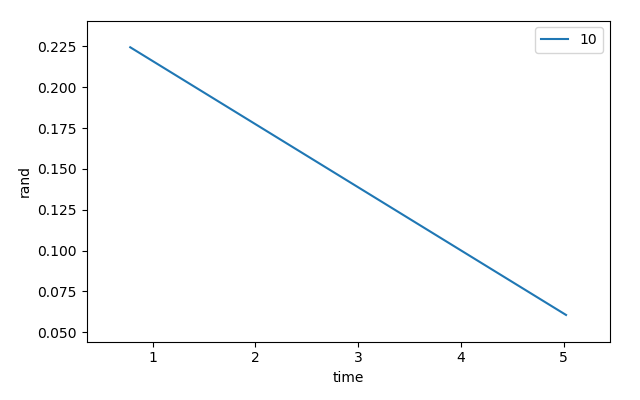

New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|                         motor1 | 13                             |
|                         motor2 | -2                             |
|                         motor3 | 42                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 00:49:26.6 |     -1.000 |      0.607 |
|         2 | 00:49:27.3 |     -0.778 |      0.739 |
|         3 | 00:49:27.8 |     -0.556 |      0.857 |
|         4 | 00:49:28.3 |     -0.333 |      0.946 |
|         5 | 00:49:28.8 |     -0.111 |      0.994 |
|         6 | 00:49:29.4 |      0.111 |      0.994 |
|         7 | 00:49:30.0 |      0.333 |      0.946 |
|         8 | 00:49:30.5 |      0.556 |      0.857 |


('d1a34177-9c52-46e8-a08c-3f70e316c376',)

In [52]:
RE(scan([det], motor, -1, 1, 10))

Notice

``New stream: 'rand_monitor'``

and a new figure. But the Best-Effort Callback doesn't show us the numbers from monitor readings. (There's just not enough room.)

In [58]:
h = db[-1]
h.table('rand_monitor')

,time,rand
seq_num,,
2,2017-12-14 00:49:26.661978,0.224500
3,2017-12-14 00:49:30.900930,0.060599


What streams do we have? Another good `Header` method to know:

In [57]:
h.stream_names

['baseline', 'rand_monitor', 'primary']

### Resampling data on time to compare across streams

`Header.table` returns a `pandas.DataFrame`. Pandas is a great library for handling time series data.

How can we plot `rand` vs `motor` to see if they are correlated? (We don't have enough data in this toy example, but bear with me....)

In [65]:
import pandas as pd
df = pd.concat([h.table('rand_monitor').set_index('time'),
                h.table('primary').set_index('time')], axis=0)
df

,det,motor,motor_setpoint,rand
time,,,,
2017-12-14 00:49:26.661978,NaN,NaN,NaN,0.224500
2017-12-14 00:49:30.900930,NaN,NaN,NaN,0.060599
2017-12-14 00:49:26.699780,0.606531,-1.000000,-1.000000,NaN
2017-12-14 00:49:27.322642,0.738991,-0.777778,-0.777778,NaN
2017-12-14 00:49:27.837319,0.856997,-0.555556,-0.555556,NaN
2017-12-14 00:49:28.351692,0.945959,-0.333333,-0.333333,NaN
2017-12-14 00:49:28.867223,0.993846,-0.111111,-0.111111,NaN
2017-12-14 00:49:29.480464,0.993846,0.111111,0.111111,NaN
2017-12-14 00:49:30.041145,0.945959,0.333333,0.333333,NaN


In [69]:
df.sort_index()

,det,motor,motor_setpoint,rand
time,,,,
2017-12-14 00:49:26.661978,NaN,NaN,NaN,0.224500
2017-12-14 00:49:26.699780,0.606531,-1.000000,-1.000000,NaN
2017-12-14 00:49:27.322642,0.738991,-0.777778,-0.777778,NaN
2017-12-14 00:49:27.837319,0.856997,-0.555556,-0.555556,NaN
2017-12-14 00:49:28.351692,0.945959,-0.333333,-0.333333,NaN
2017-12-14 00:49:28.867223,0.993846,-0.111111,-0.111111,NaN
2017-12-14 00:49:29.480464,0.993846,0.111111,0.111111,NaN
2017-12-14 00:49:30.041145,0.945959,0.333333,0.333333,NaN
2017-12-14 00:49:30.555581,0.856997,0.555556,0.555556,NaN


In [70]:
df.sort_index().ffill()

,det,motor,motor_setpoint,rand
time,,,,
2017-12-14 00:49:26.661978,NaN,NaN,NaN,0.224500
2017-12-14 00:49:26.699780,0.606531,-1.000000,-1.000000,0.224500
2017-12-14 00:49:27.322642,0.738991,-0.777778,-0.777778,0.224500
2017-12-14 00:49:27.837319,0.856997,-0.555556,-0.555556,0.224500
2017-12-14 00:49:28.351692,0.945959,-0.333333,-0.333333,0.224500
2017-12-14 00:49:28.867223,0.993846,-0.111111,-0.111111,0.224500
2017-12-14 00:49:29.480464,0.993846,0.111111,0.111111,0.224500
2017-12-14 00:49:30.041145,0.945959,0.333333,0.333333,0.224500
2017-12-14 00:49:30.555581,0.856997,0.555556,0.555556,0.224500


Now that `rand` and `motor` have a shared time base, we can plot them against each other.

<IPython.core.display.Javascript object>


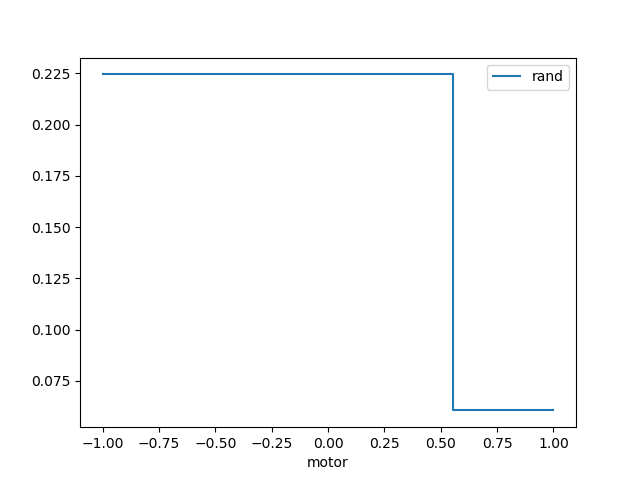

In [72]:
df.sort_index().ffill().plot(x='motor', y='rand')

### Reviewing and removing Supplemental Data sources

In [73]:
sd

SupplementalData(baseline=[SynAxis(prefix='', name='motor1', read_attrs=['readback', 'setpoint'], configuration_attrs=[]), SynAxis(prefix='', name='motor2', read_attrs=['readback', 'setpoint'], configuration_attrs=[]), SynAxis(prefix='', name='motor3', read_attrs=['readback', 'setpoint'], configuration_attrs=[])], monitors=[SynPeriodicSignal(name='rand', value=0.16593327194053853, timestamp=1513231263.873874)], flyers=[])

In [74]:
sd.monitors

[SynPeriodicSignal(name='rand', value=0.7613027413168526, timestamp=1513231323.522429)]

In [75]:
sd.monitors.clear()  # or just sd.monitors = []

In [81]:
sd.monitors

[]

### Hiding baseline readings (but still taking them)

In [82]:
RE(scan(d, motor, -1, 1, 10))

Transient Scan ID: 12     Time: 2017/12/14 01:03:38
Persistent Unique Scan ID: '78d59439-54ac-4a17-8000-08bd594e0d0b'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|                         motor1 | 13                             |
|                         motor2 | -2                             |
|                         motor3 | 42                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 01:03:38.9 |     -1.000 |      0.607 |
|         2 | 01:03:39.4 |     -0.778 |      0.739 |
|         3 | 01:03:39.9 |     -0.556 |      0.857 |
|         4 | 01:03:40.5 |     -0.333 |      0.946 |
|         5 | 01:03:41.0 |     -0.111 |      0.994 |
|         6 | 01:03:41.6 |      0.111 |  

('78d59439-54ac-4a17-8000-08bd594e0d0b',)

In [83]:
bec.disable_baseline()  # turns off VISUALIZATION only

In [84]:
RE(scan(d, motor, -1, 1, 10))

Transient Scan ID: 13     Time: 2017/12/14 01:04:35
Persistent Unique Scan ID: 'd03448b5-be69-4bc6-932a-14f8f083cf6c'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 01:04:35.8 |     -1.000 |      0.607 |
|         2 | 01:04:36.3 |     -0.778 |      0.739 |
|         3 | 01:04:36.9 |     -0.556 |      0.857 |
|         4 | 01:04:37.5 |     -0.333 |      0.946 |
|         5 | 01:04:38.0 |     -0.111 |      0.994 |
|         6 | 01:04:38.7 |      0.111 |      0.994 |
|         7 | 01:04:39.2 |      0.333 |      0.946 |
|         8 | 01:04:39.8 |      0.556 |      0.857 |
|         9 | 01:04:40.4 |      0.778 |      0.739 |
|        10 | 01:04:40.9 |      1.000 |      0.607 |
+-----------+------------+------------+------------+
generator scan ['d03448'] (scan num: 13)


('d03448b5-be69-4bc6-932a-14f8f083cf6c',)

We know that baseline data is still being recorded because ``New stream: 'baseline'`` is still there, and we can of course access the data.

In [85]:
db[-1].table('baseline')

,time,motor1,motor1_setpoint,motor2,motor2_setpoint,motor3,motor3_setpoint
seq_num,,,,,,,
1,2017-12-14 01:04:35.248432,13,13,-2,-2,42,42
2,2017-12-14 01:04:41.059705,13,13,-2,-2,42,42


Use `bec.<TAB>` to see other options for tuning the Best-Effort Callback. It will become much more extensible/customizable in later versions.